In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",'Active Risk': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}",'IR': "{:.2f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

## Momentum Backtest

To do
- add volatility
- add fundamental data
- try different things
    - Acceleration
- Use daily data 
- Add rebalancing options, daily, monthly...

In [4]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

In [5]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

In [6]:
# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]

data_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)


In [7]:
ml_pred_df = pd.read_csv('stat_analysis/XGBOOST_pred.csv')
ml_pred_df['d'] = pd.to_datetime(ml_pred_df['d'])
ml_pred_df = ml_pred_df.set_index(['d', 'insID'])

data_df = data_df.join(ml_pred_df, on=['d','insID'],how='left')

### SETTINGS FOR BACKTEST

In [8]:
min_MCAP = 500
min_liq = 0.5
not_secors = [] #'finance_RE'
not_markets = []

data_df=data_df[ ~data_df['sector'].isin(not_secors)]
data_df=data_df[ ~data_df['market'].isin(not_markets)]
data_df = data_df[data_df['MCAP']>min_MCAP]
#data_df = data_df[data_df['MA50_VOL']>min_liq]

### RANKS

In [9]:
### Momentum Ranks


#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)

data_df['res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=False)
data_df['res_mom6_rank'] = data_df['res_mom6'].groupby(level='d').rank(ascending=False)
data_df['res_mom3_rank'] = data_df['res_mom3'].groupby(level='d').rank(ascending=False)

data_df['2y_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['12m_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['6m_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['3m_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['1m_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=False, method = 'first')





data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)
data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)
data_df['SUE_Q_rank'] = data_df['SUE_Q'].groupby(level='d').rank(ascending=False)



### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(INT_MOM = x['12m_high_rank'] +x.EAR_std_rank + x.mom12_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True
data_df['INT_MOM_rank'] = data_df['INT_MOM'].groupby(level='d').rank(ascending=True)  #should be True




data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank +x.EAR_std_rank ))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [10]:
##VALUATION MEASURES

#### SET NEGATIVE MULTIPLES TO MAX, MAKES NO SENSE OTHERWISE

for ratio in ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']:
    data_df.loc[data_df[ratio]< 0,ratio] = data_df[ratio].max()



data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['PS_rank'] = data_df['PS'].groupby(level='d').rank(ascending=True) #low is good
data_df['PFCF_rank'] = data_df['PFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['DIVY_rank'] = data_df['DIV_Y'].groupby(level='d').rank(ascending=False) #high is good


#### VALUE COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank ))

data_df['VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=True)  #should be True


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC2 = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank + x.ag_rank))

data_df['VC2_rank'] = data_df['VC2'].groupby(level='d').rank(ascending=True)  #should be True


In [11]:
### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROA_rank'] = data_df['ROA'].groupby(level='d').rank(ascending=False) #high is good
data_df['FCFROE_rank'] = data_df['FCFROE'].groupby(level='d').rank(ascending=False) #high is good


#### QUALITY COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QC = x.GPA_rank + x.ROIC_rank + x.ROE_rank + x.AT_rank + x.FCFROE_rank))

data_df['QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=True)  #should be True



In [12]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.VC_rank + x.QC_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_mom_rank ))#VQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod_QM = x.GPA_rank + x.ear_mom_rank + x.SUE_rank))#VQ




### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.VC_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC_rank + x.QC_rank + x.ear_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod_QM_rank'] = data_df['mod_QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [13]:
### ANTI STRATEGIES
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True


########

data_df['2y_low_rank'] = data_df['low_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_low_rank'] = data_df['low_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_low_rank'] = data_df['low_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_low_rank'] = data_df['low_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_low_rank'] = data_df['low_1m'].groupby(level='d').rank(ascending=True, method = 'first')


#Broken highs

data_df['2y_broken_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_broke_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_broken_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_broken_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_broken_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=True, method = 'first')


#################
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True

data_df['high_vol_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=False)



In [14]:
### MISC STRATEGIES
#data_df['MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=False)
#data_df['anti_MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=True)

### ML STRATEGY
data_df['ML_rank'] = data_df['xgboost_pred'].groupby(level='d').rank(ascending=False, method = 'first').dropna()  #should be True
#data_df['alt_ML_rank'] = data_df['xgboost_pred'].groupby(level='d').rank(ascending=False)  #should be True

# SKEW
data_df['low_skew_rank'] = data_df['skew'].groupby(level='d').rank(ascending=True)
data_df['high_skew_rank'] = data_df['skew'].groupby(level='d').rank(ascending=False)


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_skew = x.ear_std_mom_rank +x.low_skew_rank ))

data_df['mom_skew_rank'] = data_df['mom_skew'].groupby(level='d').rank(ascending=True)  #should be True


### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [15]:
values_strats_list = ['ag_rank', 'PE_rank','PB_rank','EVEBIT_rank', 'EVFCF_rank', 'PS_rank', 
               'PFCF_rank','DIVY_rank','VC_rank', 'VC2_rank']

quality_strats_list = ['GPA_rank', 'ROIC_rank', 'ROE_rank', 'AT_rank', 'ROA_rank', 'FCFROE_rank', 'QC_rank']

composite_strats_list = ['QC_rank', 'VC_rank', 'ear_std_mom_rank', 'VM_rank', 'QM_rank','VQ_rank', 'VMQ_rank', 'twin_mom_rank', 'mod_QM_rank']

momentum_strats_list = ['EAR_std_rank', 'comb_mom_rank','ear_std_mom_rank', 'focus_mom_rank']

misc_strats = ['SUE_rank', 'RSURP_rank', 'fund_mom_rank', 'twin_mom_rank', 'twin_mom_alt_rank', 'EAR_SUE_rank']


mom_ls_strats = ['ear_std_mom_rank', 'comb_mom_rank', 'bad_EAR_std_rank', 'neg_mom_rank', 'bad_mom_rank', 'EAR_std_rank']

bad_strats = ['bad_QM_rank', 'bad_mom_rank','dog_shit_rank' ]


################

best_strats = ['SUE_rank', 'VMQ_rank', 'ear_std_mom_rank', 'QM_rank', 'focus_mom_rank', 'volatility_rank']

high_low_strats = ['12m_low_rank', '6m_low_rank', '12m_high_rank', '6m_high_rank', '3m_low_rank', '3m_high_rank']

highs = ['2y_high_rank','12m_high_rank', '6m_high_rank', '3m_high_rank', '1m_high_rank' ]
lows = ['2y_low_rank','12m_low_rank', '6m_low_rank', '3m_low_rank', '1m_low_rank' ]



In [22]:
top_n = 30
rebal_period = 1

strat_df = pd.DataFrame()
strats_test = ['accel_rank']

for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [23]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [24]:
#result['SISU'] = 0.5*result['VMQ_rank'] + 0.5*result['ear_std_mom_rank']
#result['LS_QM'] = 1.3*result['QM_rank'] - 0.3*result['bad_QM_rank']
#result['LS_EAR_MOM'] = 1*result['ear_std_mom_rank'] - 0.3*result['bad_mom_rank']
#result['LS_BREAK'] = 1*result['12m_high_rank'] - 0.3*result['12m_low_rank']

In [25]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

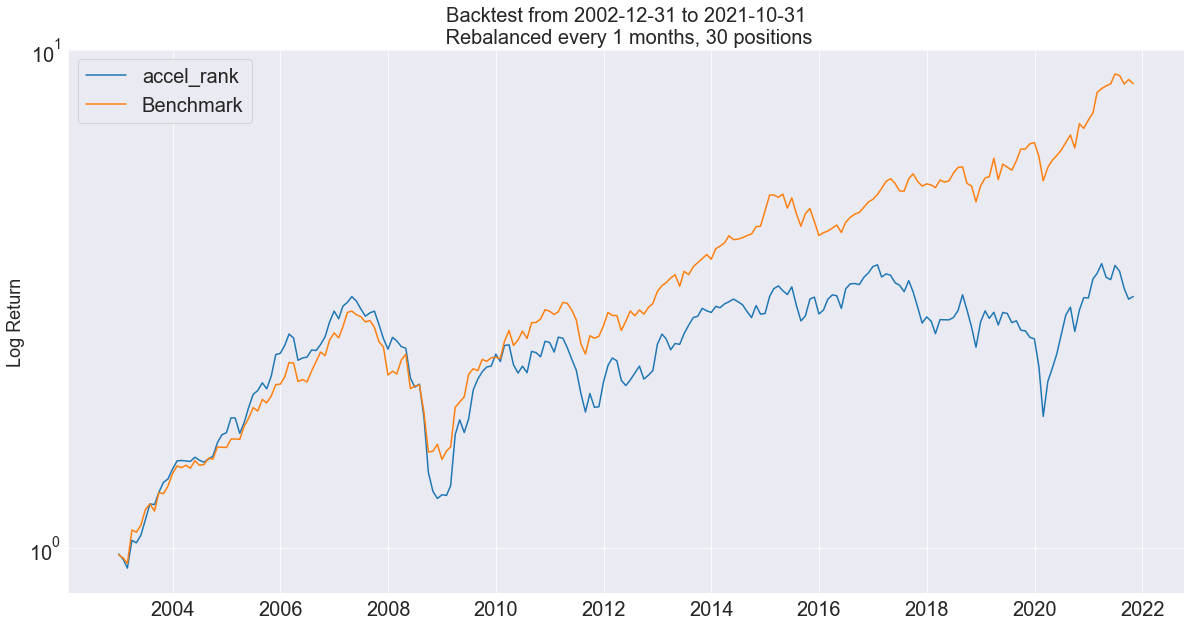

In [26]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end) +
          "\n Rebalanced every " + str(rebal_period) + " months, " + str(top_n) + " positions", fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [27]:
data_names = result.columns
strategy_evaluation(result_cum,data_names,freq = 'M')

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,Active Risk,IR
accel_rank,6.5%,20.6%,0.3,0.4,-61.0%,0.11,13.4%,-0.39
Benchmark,12.2%,16.2%,0.8,0.9,-50.0%,0.24,0.0%,0.00


In [91]:
correlation_map(result_cum)


,3m_low_rank,3m_broken_high_rank,Benchmark
3m_low_rank,1.00,0.68,0.69
3m_broken_high_rank,0.68,1.00,0.71
Benchmark,0.69,0.71,1.00


In [97]:
#Calculate log returns
result_log = np.log(result_cum) - np.log(result_cum.shift(1))
result_log = result_log.dropna()

#Calculate relative returns
rel_result = result_log.subtract((pd.Series(result['Benchmark'])), axis = 0).dropna()
rel_result = rel_result.drop(['Benchmark'], axis= 1)

#calculate Max DD
Roll_Max = (np.exp(rel_result)).cumprod().cummax()
Daily_Drawdown = (np.exp(rel_result)).cumprod()/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)


# the t-value is easily computed with numpy
t = (np.mean(rel_result))/(rel_result.std(ddof=1)/np.sqrt(len(rel_result)))



# DRAWDOWN LENGTH
#xs = rel_result.cumsum().dropna()
xs = rel_result.cumsum().dropna()
cum_drawdown = np.maximum.accumulate(xs) - xs
time_df = pd.DataFrame(cum_drawdown.apply(np.argmax), columns=['end'])
time_df['start'] = np.nan

for col in xs.columns:
    tmp_idx = xs.index[time_df.loc[col,'end']]
    time_df.loc[col,'start'] = np.argmax(xs.loc[:tmp_idx,col])
time_df['L'] = time_df['end'] - time_df['start']


#CREATE DASHBOARD
rel_perf_df = pd.DataFrame(columns = Max_Daily_Drawdown.columns, index=['Max rel. DD','Longest rel. DD', 't-value vs. index'])
rel_perf_df.loc['t-value vs. index',:] = round(t,2)
rel_perf_df.loc['Max rel. DD',:] = Max_Daily_Drawdown.values
#rel_perf_df.loc['Longest rel. DD', :] = time_df['L'].values


In [98]:
rel_perf_df

,3m_low_rank,3m_broken_high_rank
Max rel. DD,-0.49,-0.99
Longest rel. DD,NaN,NaN
t-value vs. index,1.25,-4.24


In [28]:
#test = result_log.cumsum()['ear_std_mom_rank']
test = rel_result.cumsum()['comb_mom_rank']

#calculate Max DD
Roll_Max = test.cummax()
Daily_Drawdown = test - Roll_Max
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)


plt.figure(figsize=(20,10));
i = np.argmax(np.maximum.accumulate(test) - test) # end of the period
j = np.argmax(test[:i]) # start of period
plt.plot(test);
plt.plot([test.index[i], test.index[j]], [test[i], test[j]], 'X', color='Red', markersize=10);

print("Max Length of DD:", i-j)
print("Max DD:", Max_Daily_Drawdown[0])

KeyError: 'comb_mom_rank'

In [29]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1

In [30]:
result_by_year

,low_skew_rank,high_skew_rank,Benchmark
d,,,
2002,-0.055213,-0.036790,-0.031277
2003,0.433371,0.599412,0.454865
2004,0.250834,0.138613,0.129076
2005,0.460073,0.494825,0.339885
2006,0.322775,0.220002,0.267139
2007,-0.256924,-0.230090,-0.177036
2008,-0.337587,-0.420132,-0.322967
2009,0.580134,0.930627,0.603420
2010,0.150768,0.232234,0.237346


## Performance by rebalancing date

- measure by sharpe ratio

In [66]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [67]:
rebal_diff_df

,1,2,3,4,5,6,7,8,9,10,11,12
EAR_std_rank,0.81766,0.728297,0.722397,0.736511,0.731756,0.731423,0.707094,0.771736,0.622951,0.662026,0.726701,0.720976
comb_mom_rank,0.880143,0.941497,0.829387,0.959093,0.697566,0.990716,0.7042,0.893399,0.78799,0.514114,0.611596,0.887412
ear_std_mom_rank,1.179618,1.112795,1.044443,1.090463,0.831083,1.079166,1.169582,0.982051,0.894996,0.629523,0.743739,1.086619
focus_mom_rank,1.132591,1.19413,1.18294,1.141512,1.122684,1.257947,1.237928,1.075397,1.107488,1.02521,1.121979,1.300343
ML_rank,1.041533,1.009596,1.219856,1.044826,1.086024,1.133457,1.101062,1.036254,1.123083,1.186995,0.984348,1.114183


In [68]:
turnover_df

,1,2,3,4,5,6,7,8,9,10,11,12
EAR_std_rank,2.939496,2.289076,1.941176,1.598319,1.416807,1.30084,1.12437,1.063866,1.018487,0.902521,0.887395,0.867227
comb_mom_rank,5.282096,3.694323,2.939738,2.384279,1.912664,1.629694,1.472489,1.268122,1.163319,1.037555,0.974672,0.88559
ear_std_mom_rank,5.072489,3.489956,2.819214,2.216594,1.855022,1.613974,1.409607,1.262882,1.147598,1.021834,0.917031,0.91179
focus_mom_rank,4.889083,3.343231,2.69345,2.122271,1.760699,1.572052,1.315284,1.236681,1.142358,1.027074,0.922271,0.880349
ML_rank,3.128384,2.179913,1.79214,1.598253,1.367686,1.179039,1.137118,1.000873,0.953712,0.859389,0.838428,0.791266


In [29]:
## Get current top N of different ranks


current_port_df = data_df.copy()#['Name']
current_port_df = current_port_df.reset_index(level='insID', drop=True)
current_port_df = current_port_df[current_port_df.index ==current_port_df.sort_index().index.unique()[-1]]

current_port_df.sort_values(by = 'accel_rank')[['Name','ear_mom_rank', 'focus_mom_rank', 'acceleration']].head(20)



,Name,ear_mom_rank,focus_mom_rank,acceleration
d,,,,
2021-12-31,Studentbostäder,348.5,400.0,1.068722
2021-12-31,Athanase Innovation,353.0,415.0,0.931479
2021-12-31,InDex Pharmaceuticals,245.5,318.0,0.713563
2021-12-31,SpectrumOne,416.0,440.0,0.667005
2021-12-31,Isofol Medical,312.0,385.0,0.651739
2021-12-31,Allarity Therapeutics,94.0,152.0,0.578025
2021-12-31,Cantargia,390.0,437.5,0.447103
2021-12-31,Enzymatica,464.5,475.0,0.408545
2021-12-31,Ascelia Pharma,362.0,360.0,0.351202


In [142]:
comp_rank_df = data_df.copy()
comp_rank_df = comp_rank_df[comp_rank_df['Name'] == 'Kindred']
comp_rank_df = comp_rank_df.droplevel('insID')
#comp_rank_df[['c','PFCF', 'EVFCF']]

In [206]:
#comp_rank_df.columns
#comp_rank_df['PFCF'].plot()
#plt.figure(figsize=(20,10));
#plt.plot(comp_rank_df['focus_mom_rank'])

##  Save returns as pandas dataframe

In [ ]:
result.to_csv("data/strategy_returns.csv")